In [12]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer, ColorMode
# evaluation
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.modeling import build_model

# if your dataset is in COCO format
from detectron2.data.datasets import register_coco_instances

# for logging results
import wandb

## Data

In [4]:
register_coco_instances("my_df_train", {}, "../data/train/json_for_train/train.json", "../data/train/train/image/")
register_coco_instances("my_df_val", {}, "../data/validation/json_for_validation/val_deepfashion2.json", "../data/validation/validation/image/")
register_coco_instances("my_df_test", {}, "../data/test/json_for_test/all_test_info.json", "../data/test/test/image")

In [5]:
my_df_train = DatasetCatalog.get("my_df_train")

[03/22 14:17:38 d2.data.datasets.coco]: Loading ../data/train/json_for_train/train.json takes 6.18 seconds.
[03/22 14:17:39 d2.data.datasets.coco]: Loaded 191961 images in COCO format from ../data/train/json_for_train/train.json


In [4]:
my_df_val = DatasetCatalog.get("my_df_val")

[03/09 17:43:00 d2.data.datasets.coco]: Loading ../data/validation/json_for_validation/val_deepfashion2.json takes 4.10 seconds.
[03/09 17:43:01 d2.data.datasets.coco]: Loaded 32153 images in COCO format from ../data/validation/json_for_validation/val_deepfashion2.json


## Model

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"))

cfg.DATASETS.TRAIN = ("my_df_train",)
cfg.DATASETS.TEST = ()

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 + 13 # Background + number of classes
cfg.MODEL.RETINANET.NUM_CLASSES = 1 + 13 # Background + number of classes

cfg.SOLVER.CHECKPOINT_PERIOD = 5000

# cfg.SOLVER.MAX_ITER = 100
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.GAMMA = 0.1
# The iteration number to decrease learning rate by GAMMA.
# cfg.SOLVER.STEPS = (50, )
cfg.SOLVER.IMS_PER_BATCH = 2

cfg.INPUT.MASK_FORMAT = "bitmask"

### Tracking model

In [14]:
wandb.init(project='fashion-segmentation', sync_tensorboard=True)

wandb: Currently logged in as: taya (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Training

In [7]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/09 17:43:06 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[03/09 17:43:14 d2.data.datasets.coco]: Loading ../data/train/json_for_train/train.json takes 8.85 seconds.
[03/09 17:43:15 d2.data.datasets.coco]: Loaded 191961 images in COCO format from ../data/train/json_for_train/train.json
[03/09 17:43:19 d2.data.build]: Removed 0 images with no usable annotations. 191961 images left.
[03/09 17:43:25 d2.data.build]: Distribution of instances among all 13 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| short_sleev.. | 71645        | long_sleeve.. | 36064        | short_sleev.. | 543          |
| long_sleeve.. | 13457        |     vest      | 16095        |     sling     | 1985         |
|    shorts     | 36616        |   trousers    | 55387        |     skirt     | 30835        |
| short_sleev.. | 17211        | long_sleeve.. | 7907         |  vest_dress   | 17949        |
|  sling_dress  | 649

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (15, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (56, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (56,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (14, 256, 1, 

[03/09 17:43:28 d2.engine.train_loop]: Starting training from iteration 0


/home/furiousteabag/Projects/envs/base/lib/python3.6/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[03/09 17:43:43 d2.utils.events]:  eta: 17:43:53  iter: 19  total_loss: 2.785  loss_cls: 1.864  loss_box_reg: 0.1896  loss_mask: 0.6902  loss_rpn_cls: 0.01685  loss_rpn_loc: 0.01536  time: 0.7138  data_time: 0.0418  lr: 0.00039962  max_mem: 3478M
[03/09 17:43:57 d2.utils.events]:  eta: 17:23:28  iter: 39  total_loss: 1.139  loss_cls: 0.2568  loss_box_reg: 0.1627  loss_mask: 0.6568  loss_rpn_cls: 0.01138  loss_rpn_loc: 0.01349  time: 0.6975  data_time: 0.0057  lr: 0.00079922  max_mem: 3478M
[03/09 17:44:11 d2.utils.events]:  eta: 17:17:55  iter: 59  total_loss: 1.022  loss_cls: 0.2187  loss_box_reg: 0.1843  loss_mask: 0.5935  loss_rpn_cls: 0.01202  loss_rpn_loc: 0.01432  time: 0.6933  data_time: 0.0066  lr: 0.0011988  max_mem: 3478M
[03/09 17:44:24 d2.utils.events]:  eta: 17:17:41  iter: 79  total_loss: 0.9259  loss_cls: 0.2159  loss_box_reg: 0.187  loss_mask: 0.4764  loss_rpn_cls: 0.006906  loss_rpn_loc: 0.01239  time: 0.6937  data_time: 0.0056  lr: 0.0015984  max_mem: 3478M
[03/09 17:

### Inference & evaluation using the trained model

In [7]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_df_val", )
predictor = DefaultPredictor(cfg)

[03/22 14:18:25 d2.data.datasets.coco]: Loading ../data/validation/json_for_validation/val_deepfashion2.json takes 6.12 seconds.
[03/22 14:18:25 d2.data.datasets.coco]: Loaded 32153 images in COCO format from ../data/validation/json_for_validation/val_deepfashion2.json


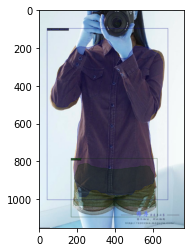

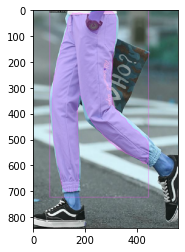

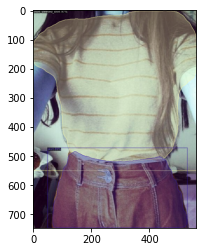

In [9]:
dataset_dicts = DatasetCatalog.get(cfg.DATASETS.TEST[0])

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2, instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

### Evaluation

In [ ]:
evaluator = COCOEvaluator("my_df_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_df_val")
wandb.log(inference_on_dataset(build_model(cfg), val_loader, evaluator))

WARNING [03/22 16:34:06 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
[03/22 16:34:14 d2.data.datasets.coco]: Loading ../data/validation/json_for_validation/val_deepfashion2.json takes 4.14 seconds.
[03/22 16:34:14 d2.data.datasets.coco]: Loaded 32153 images in COCO format from ../data/validation/json_for_validation/val_deepfashion2.json
[03/22 16:34:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/22 16:34:18 d2.data.common]: Serializing 32153 elements to byte tensors and concatenating them all ...
[03/22 16:34:19 d2.data.common]: Serialized dataset takes 92.30 MiB
[03/22 16:34:20 d2.evaluation.evaluator]: Start inference on 32153 images
[03/22 16:34:22 d2.evaluation.evaluator]: Inference done 11/32153. 0.1203 s / img. ETA=1:06:04
[03/22 16:34:27 d2.evaluation.evaluator]: Inferenc

[03/22 16:40:11 d2.evaluation.evaluator]: Inference done 2876/32153. 0.1181 s / img. ETA=0:59:29
[03/22 16:40:16 d2.evaluation.evaluator]: Inference done 2918/32153. 0.1181 s / img. ETA=0:59:24
[03/22 16:40:21 d2.evaluation.evaluator]: Inference done 2960/32153. 0.1181 s / img. ETA=0:59:19
[03/22 16:40:26 d2.evaluation.evaluator]: Inference done 3002/32153. 0.1180 s / img. ETA=0:59:13
[03/22 16:40:32 d2.evaluation.evaluator]: Inference done 3044/32153. 0.1180 s / img. ETA=0:59:07
[03/22 16:40:37 d2.evaluation.evaluator]: Inference done 3086/32153. 0.1180 s / img. ETA=0:59:02
[03/22 16:40:42 d2.evaluation.evaluator]: Inference done 3127/32153. 0.1180 s / img. ETA=0:58:58
[03/22 16:40:47 d2.evaluation.evaluator]: Inference done 3167/32153. 0.1181 s / img. ETA=0:58:54
[03/22 16:40:52 d2.evaluation.evaluator]: Inference done 3209/32153. 0.1180 s / img. ETA=0:58:48
[03/22 16:40:57 d2.evaluation.evaluator]: Inference done 3250/32153. 0.1181 s / img. ETA=0:58:43
[03/22 16:41:02 d2.evaluation.